## Step 1. Import Libraries

In [51]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import sklearn

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

## Step 2. Extract CPI data from BLS

In [117]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUUR0000SA0L1E'],"startyear":"2015", "endyear":"2023"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)

In [246]:
json_data

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 185,
 'message': [],
 'Results': {'series': [{'seriesID': 'CUUR0000SA0L1E',
    'data': [{'year': '2023',
      'period': 'M10',
      'periodName': 'October',
      'latest': 'true',
      'value': '311.380',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M09',
      'periodName': 'September',
      'value': '310.817',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M08',
      'periodName': 'August',
      'value': '310.103',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M07',
      'periodName': 'July',
      'value': '309.402',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M06',
      'periodName': 'June',
      'value': '308.910',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M05',
      'periodName': 'May',
      'value': '308.096',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M04',
      'periodName': 'April',
      'val

In [118]:
def get_time_idx(x):
    if x['month'] <= 9:
        date = f"{x['year']}-0{x['month']}"
    else:
        date = f"{x['year']}-{x['month']}"
    return date

def get_data(json_data):
    df = pd.DataFrame(json_data['Results']['series'][0]['data']).iloc[:,[0,1,2,4]]
    df['month'] = df['period'].apply(lambda x : int(x[1:]))
    df.drop(columns=['period'], inplace=True)

    df['date'] = df.apply(lambda x : get_time_idx(x), axis=1)
    df.drop(columns=['year','periodName','month'], inplace=True)
    df = df.sort_values(by='date').set_index('date')

    df['value'] = df['value'].astype('float64')
    df['yoy'] = df['value'].pct_change(periods=12)
    df = df.dropna()
    return df

- yoy: 작년 동월 대비 변화량

In [119]:
df = get_data(json_data)
df

,value,yoy
date,,
2016-01,244.528,0.022069
2016-02,245.680,0.023313
2016-03,246.358,0.021948
2016-04,246.992,0.021464
2016-05,247.544,0.022406
...,...,...
2023-06,308.910,0.048290
2023-07,309.402,0.046529
2023-08,310.103,0.043492


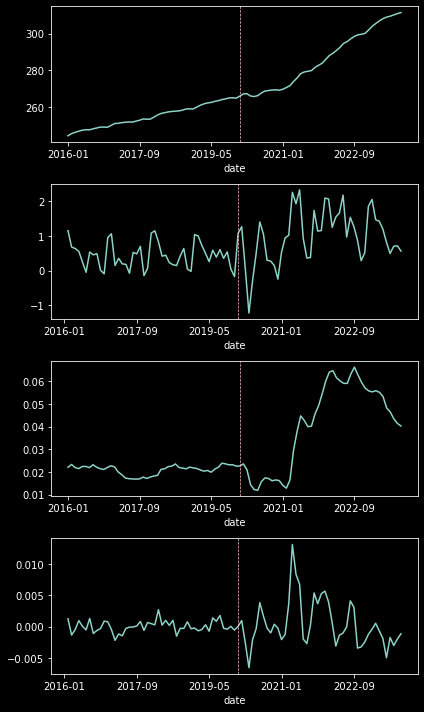

In [146]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(6,10))

event_idx = df.index.to_list().index('2020-01')

df['value'].plot(ax=axes[0])
axes[0].axvline(x=event_idx, c='pink', linestyle='--', linewidth=0.7)

df['value'].diff().plot(ax=axes[1])
axes[1].axvline(x=event_idx, c='pink', linestyle='--', linewidth=0.7)

df['yoy'].plot(ax=axes[2])
axes[2].axvline(x=event_idx, c='pink', linestyle='--', linewidth=0.7)

df['yoy'].diff().plot(ax=axes[3])
axes[3].axvline(x=event_idx, c='pink', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

In [264]:
df.loc['2019-01':'2019-12']

,value,yoy
date,,
2019-01,260.122,0.021536
2019-02,261.114,0.020842
2019-03,261.836,0.020366
2019-04,262.332,0.020648
2019-05,262.590,0.019890
2019-06,263.177,0.021265
2019-07,263.566,0.022101
2019-08,264.169,0.023863
2019-09,264.522,0.023577


In [269]:
from scipy import stats


print(stats.ttest_rel(df['value'].diff().dropna().loc['2019-01':'2019-12'], 
                      df['value'].diff().dropna().loc['2021-01':'2021-12']))

print(stats.ttest_rel(df['yoy'].loc['2019-01':'2019-12'], 
                      df['yoy'].loc['2021-01':'2021-12']))

print(stats.ttest_rel(df['yoy'].diff().dropna().loc['2019-01':'2019-12'], 
                      df['yoy'].diff().dropna().loc['2021-01':'2021-12']))

Ttest_relResult(statistic=-3.0930454921018695, pvalue=0.010230311851951779)
Ttest_relResult(statistic=-3.542850119128582, pvalue=0.004609581345573239)
Ttest_relResult(statistic=-2.108403107832839, pvalue=0.05873916489588582)


- 코로나 전후로 데이터 분포가 달라짐.
- 단, 전년동월 대비 증감값에 차분을 수행하는 경우 분포 차이가 사라짐
- '전년동월 대비 증감 변화량'은 장기간 일정 분포를 형성
- 이벤트 이후로 자르면 이벤트 전 데이터에 대한 평균회귀 성질을 고려하지 못함.


## Step 3. Check Timeseries Stationary

- 네 유형 중 어떤 것이 가장 분석에 적합한가
- 다시 말해, 어떤 데이터가 가장 높은 정상성을 보이는가


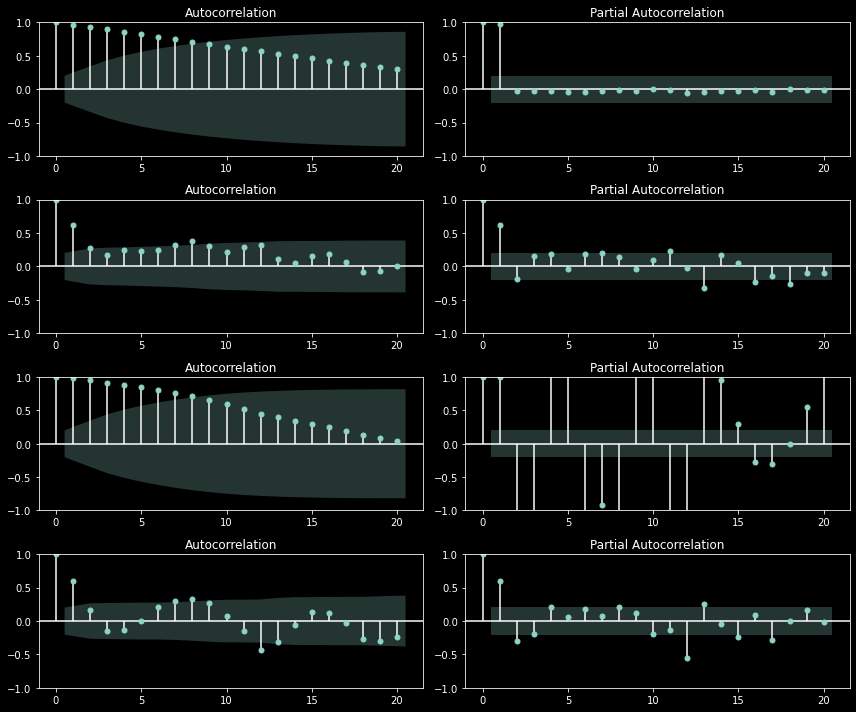

In [155]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,10))

plot_acf(df['value'], ax=axes[0,0])
plot_acf(df['value'].diff().dropna(), ax=axes[1,0])
plot_acf(df['yoy'], ax=axes[2,0])
plot_acf(df['yoy'].diff().dropna(), ax=axes[3,0])

plot_pacf(df['value'], ax=axes[0,1])
plot_pacf(df['value'].diff().dropna(), ax=axes[1,1])
plot_pacf(df['yoy'], ax=axes[2,1])
plot_pacf(df['yoy'].diff().dropna(), ax=axes[3,1])

plt.tight_layout()
plt.show()

- 원본데이터(value), 전년 동월 대비 증감(you): 자기상관성 매우 높음
- 두 데이터 모두 직전 데이터 대비 변화량(차분)을 사용하면 자기상관성 낮아짐.
- but, 직전값 1개 자기상관성 유효


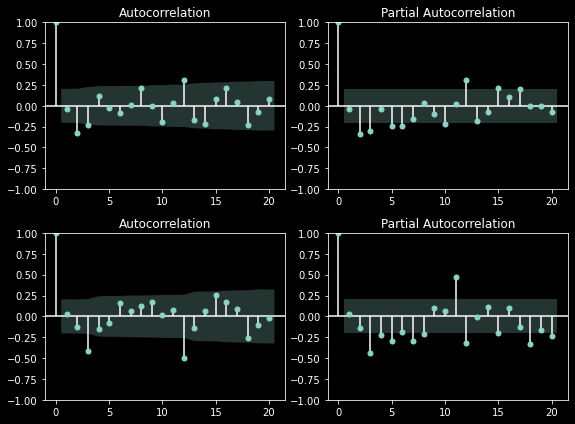

In [158]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6))

plot_acf(df['value'].diff().diff().dropna(), ax=axes[0,0])
plot_acf(df['yoy'].diff().diff().dropna(), ax=axes[1,0])

plot_pacf(df['value'].diff().diff().dropna(), ax=axes[0,1])
plot_pacf(df['yoy'].diff().diff().dropna(), ax=axes[1,1])

plt.tight_layout()
plt.show()

- 비슷해보임. 가설검정 방식 시도.

In [301]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data, name):
    result = adfuller(data.values)
    print(name)
    print(f'>> statistics: {result[0]:.3f}')
    print(f'>> p_value: {result[1]:.3f}')
    print(f'>> critical values(5%):{result[4]["5%"]:.3f}')
    if result[1] < 0.05:
        print('pass!! :)')
    else:
        print('fail :(')
    print('--------------------------')

adf_test(df['value'], name='value')
adf_test(df['value'].diff().dropna(), name='value (d:1)')
adf_test(df['value'].diff().diff().dropna(), name='value (d:2)')
adf_test(df['yoy'].dropna(), name='yoy')
adf_test(df['yoy'].diff().dropna(), name='yoy (d:1)')
adf_test(df['yoy'].diff().diff().dropna(), name='yoy (d:2)')

value
>> statistics: 2.862
>> p_value: 1.000
>> critical values(5%):-2.894
fail :(
--------------------------
value (d:1)
>> statistics: -1.404
>> p_value: 0.580
>> critical values(5%):-2.898
fail :(
--------------------------
value (d:2)
>> statistics: -3.116
>> p_value: 0.025
>> critical values(5%):-2.899
pass!! :)
--------------------------
yoy
>> statistics: -0.913
>> p_value: 0.784
>> critical values(5%):-2.904
fail :(
--------------------------
yoy (d:1)
>> statistics: -1.834
>> p_value: 0.364
>> critical values(5%):-2.905
fail :(
--------------------------
yoy (d:2)
>> statistics: -2.637
>> p_value: 0.086
>> critical values(5%):-2.905
fail :(
--------------------------


- 원본 데이터의 2차 차분값이 정상성 만족

## Step 4. ARIMA 모델링 

- (test) 자동 차분 결정

In [283]:
import pmdarima as pm
from pmdarima.arima import ndiffs


data_value = df['value']
d = ndiffs(data_value, alpha=0.05, test='adf', max_d=6)
print(f"(value) d: {d}")

data_yoy = df['yoy'].dropna()
d = ndiffs(data_yoy, alpha=0.05, test='adf', max_d=6)
print(f"(yoy) d: {d}")

(value) d: 1
(yoy) d: 2


- 자동 ar(p), i(d), ma(q), 차수 결정


In [302]:
model_value = pm.auto_arima(
            y=data_value, 
            d=1, 
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=1, 
            seasonal=False,
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=188.093, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=144.993, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=150.317, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=260.225, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=143.666, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=143.753, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=145.047, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=143.142, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=143.547, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=141.235, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=143.157, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=141.837, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=170.584, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.500 seconds


In [303]:
model_yoy = pm.auto_arima(
            y=data_yoy, 
            d=1, 
            start_p=0, max_p=3, 
            start_q=0, max_q=3, 
            m=1, 
            seasonal=False,
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-715.722, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-750.544, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-745.228, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-717.252, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-755.869, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-757.021, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-756.707, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-746.786, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-758.600, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-757.636, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-758.310, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-749.194, Time=0.06 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.984 seconds


- 잔차 검정

In [183]:
print(model_value.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   94
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -66.618
Date:                Tue, 05 Dec 2023   AIC                            141.235
Time:                        00:36:30   BIC                            151.365
Sample:                    01-01-2016   HQIC                           145.325
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7222      0.126      5.725      0.000       0.475       0.969
ma.L1          0.7906      0.116      6.837      0.000       0.564       1.017
ma.L2          0.3484      0.097      3.576      0.0

In [188]:
print(model_yoy.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   94
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 444.380
Date:                Tue, 05 Dec 2023   AIC                           -880.760
Time:                        00:37:19   BIC                           -870.630
Sample:                    01-01-2016   HQIC                          -876.670
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7229      0.129      5.585      0.000       0.469       0.977
ar.L2         -0.1489      0.123     -1.210      0.226      -0.390       0.092
ar.L3         -0.1835      0.084     -2.181      0.0

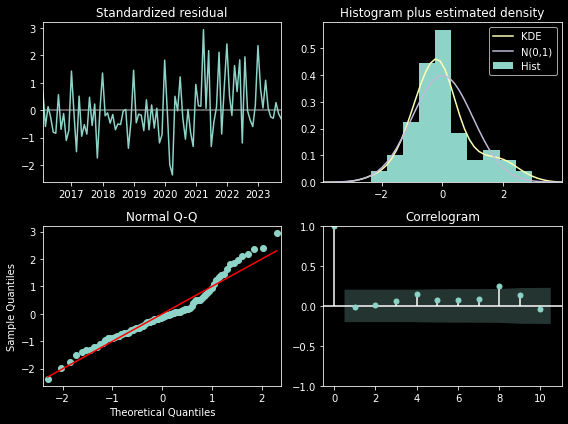

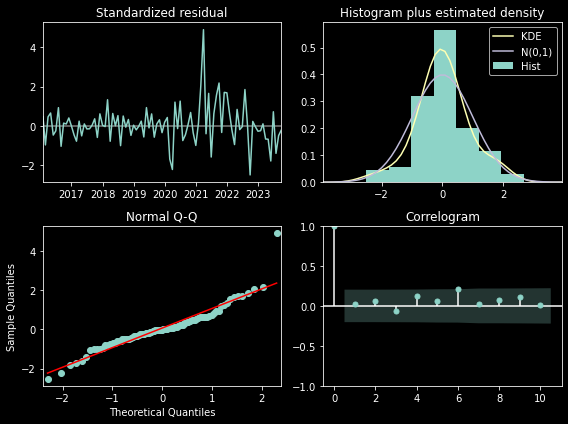

In [208]:
model_value.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

model_yoy.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

## Step 5. Predict

- value 

In [233]:
data_value

date
2016-01    244.528
2016-02    245.680
2016-03    246.358
2016-04    246.992
2016-05    247.544
            ...   
2023-06    308.910
2023-07    309.402
2023-08    310.103
2023-09    310.817
2023-10    311.380
Name: value, Length: 94, dtype: float64

In [210]:
data_value_pred = model_value.predict(n_periods=5)
data_value_pred

2023-11-01    311.956943
2023-12-01    312.625214
2024-01-01    313.347425
2024-02-01    314.069637
2024-03-01    314.791848
Freq: MS, dtype: float64

In [238]:
data_value_pred = model_value.predict(n_periods=5)
data_value_all = pd.Series(list(data_value.values) + list(data_value_pred.values)).pct_change(periods=12).dropna().reset_index(drop=True)
data_value_all

0     0.022717
1     0.022236
2     0.020020
3     0.018827
4     0.017334
        ...   
82    0.041245
83    0.041692
84    0.037705
85    0.033086
86    0.030496
Length: 87, dtype: float64

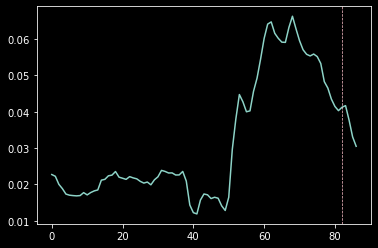

In [244]:
data_value_pred = model_value.predict(n_periods=5)
data_value_all = pd.Series(list(data_value.values) + list(data_value_pred.values)).pct_change(periods=12).dropna().reset_index(drop=True)

data_value_all.plot()
plt.axvline(x=len(data_value_all)-len(data_value_pred), c='pink', linewidth=0.7, linestyle='--')
plt.show()

- yoy

In [234]:
data_yoy

date
2016-01         NaN
2016-02         NaN
2016-03         NaN
2016-04         NaN
2016-05         NaN
             ...   
2023-06    0.048290
2023-07    0.046529
2023-08    0.043492
2023-09    0.041465
2023-10    0.040309
Name: yoy, Length: 94, dtype: float64

In [236]:
data_yoy_pred = model_yoy.predict(n_periods=5)
data_yoy_pred

2023-11-01    0.040332
2023-12-01    0.040893
2024-01-01    0.041507
2024-02-01    0.041863
2024-03-01    0.041926
Freq: MS, dtype: float64

In [239]:
data_yoy_pred = model_yoy.predict(n_periods=5)
data_yoy_all = pd.Series(list(data_yoy.values) + list(data_yoy_pred.values)).dropna().reset_index(drop=True)
data_yoy_all

0     0.022717
1     0.022236
2     0.020020
3     0.018827
4     0.017334
        ...   
82    0.040332
83    0.040893
84    0.041507
85    0.041863
86    0.041926
Length: 87, dtype: float64

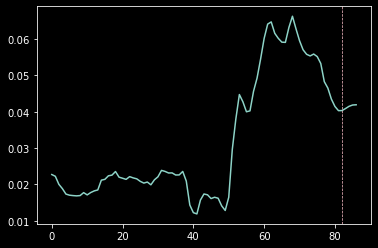

In [245]:
data_yoy_pred = model_yoy.predict(n_periods=5)
data_yoy_all = pd.Series(list(data_yoy.values) + list(data_yoy_pred.values)).dropna().reset_index(drop=True)

data_yoy_all.plot()
plt.axvline(x=len(data_yoy_all)-len(data_yoy_pred), c='pink', linewidth=0.7, linestyle='--')
plt.show()